In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import tree, metrics
from google.colab import drive
import pickle
import joblib
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/players_21.csv')

USING CORRELATION MATRIX TO DETERMINE WHAT COLUMNS TO DROP

In [ ]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['overall']

# Selecting features with high correlation in order to get good results
selected_features = correlation_with_target[abs(correlation_with_target) > 0.5].index
print(selected_features)

Index(['overall', 'potential', 'value_eur', 'wage_eur', 'release_clause_eur',
       'passing', 'dribbling', 'physic', 'attacking_short_passing',
       'movement_reactions', 'power_shot_power', 'mentality_vision',
       'mentality_composure'],
      dtype='object')


<ipython-input-48-a98e5e787ee5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


REMOVING IRRELEVANT VARIABLES BASED ON CORRELATION MATRIX AND WHAT WE DECIDED WAS IRRELEVANT



In [ ]:
df = df.drop(['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb', 'ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk','player_traits','player_tags','body_type','work_rate','preferred_foot','nation_position','nationality_name','club_position','club_name','league_name','height_cm','weight_kg','league_level','weak_foot','skill_moves','international_reputation','pace','shooting','defending','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control',   'short_name','long_name', 'release_clause_eur',  'sofifa_id', 'player_url', 'player_face_url', 'real_face', 'club_logo_url','club_flag_url','nation_logo_url','nation_flag_url','dob','club_contract_valid_until',
                   'club_joined','club_jersey_number','nationality_id','club_loaned_from','nation_jersey_number','real_face','club_team_id','nation_team_id','movement_acceleration','movement_sprint_speed','movement_agility','movement_balance','power_jumping','power_stamina','power_strength','power_long_shots',
              'mentality_aggression','mentality_positioning','mentality_penalties','mentality_interceptions','defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed',


              ],axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_positions         18944 non-null  object 
 1   overall                  18944 non-null  int64  
 2   potential                18944 non-null  int64  
 3   value_eur                18707 non-null  float64
 4   wage_eur                 18719 non-null  float64
 5   age                      18944 non-null  int64  
 6   passing                  16861 non-null  float64
 7   dribbling                16861 non-null  float64
 8   physic                   16861 non-null  float64
 9   attacking_short_passing  18944 non-null  int64  
 10  movement_reactions       18944 non-null  int64  
 11  power_shot_power         18944 non-null  int64  
 12  mentality_vision         18944 non-null  int64  
 13  mentality_composure      18944 non-null  int64  
dtypes: float64(5), int64(8

VISUAL CORRELATION MATRIX- to provide visual representation of a data-based justification of  why certain columns will be dropped





<ipython-input-51-1fcef58bc2a9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


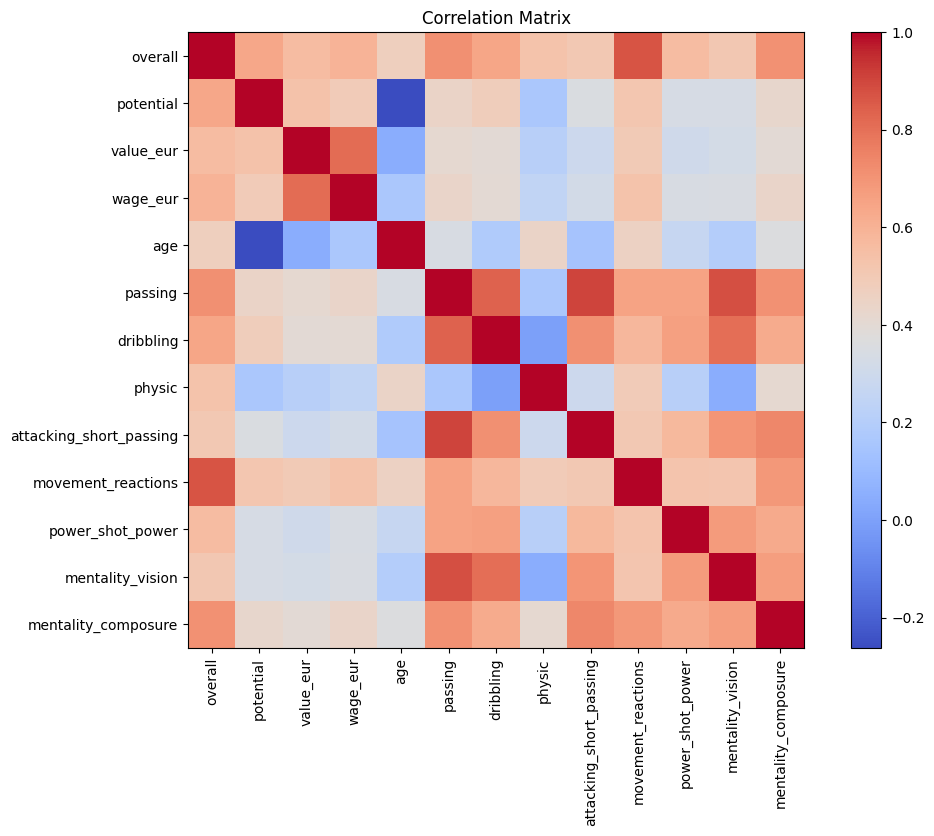

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

CLEANING DATA: Handling Missing values

In [ ]:
# separating numeric and non-numeric columns
numeric_columns = df.select_dtypes(include = [np.number]).columns
non_numeric_columns = df.select_dtypes(exclude = [np.number]).columns

numeric_imputer = SimpleImputer(strategy = 'median')
non_numeric_imputer = SimpleImputer(strategy = 'most_frequent')

df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
df[non_numeric_columns] = non_numeric_imputer.fit_transform(df[non_numeric_columns])

In [ ]:
df

,player_positions,overall,potential,value_eur,wage_eur,age,passing,dribbling,physic,attacking_short_passing,movement_reactions,power_shot_power,mentality_vision,mentality_composure
0,"RW, ST, CF",93.0,93.0,103500000.0,560000.0,33.0,91.0,95.0,65.0,91.0,94.0,86.0,95.0,96.0
1,"ST, LW",92.0,92.0,63000000.0,220000.0,35.0,81.0,89.0,77.0,82.0,95.0,94.0,82.0,95.0
2,ST,91.0,91.0,111000000.0,240000.0,31.0,78.0,85.0,82.0,84.0,93.0,89.0,79.0,88.0
3,"LW, CAM",91.0,91.0,132000000.0,270000.0,28.0,86.0,94.0,59.0,87.0,91.0,80.0,90.0,93.0
4,"CAM, CM",91.0,91.0,129000000.0,370000.0,29.0,93.0,88.0,78.0,94.0,91.0,91.0,94.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18939,CB,47.0,52.0,70000.0,1000.0,21.0,26.0,27.0,48.0,31.0,48.0,35.0,25.0,40.0
18940,CM,47.0,53.0,70000.0,1000.0,21.0,49.0,47.0,48.0,55.0,50.0,38.0,53.0,35.0
18941,CM,47.0,47.0,45000.0,2000.0,28.0,49.0,46.0,59.0,56.0,44.0,49.0,44.0,35.0
18942,ST,47.0,67.0,130000.0,500.0,17.0,40.0,53.0,40.0,45.0,53.0,50.0,49.0,45.0


ENCODING CATEGORICAL VARIABLES

In [ ]:
# Encoding categorical variables using OneHotEncoder

column_to_encode = ['player_positions']

# Applying one-hot encoding to the selected columns
df_encoded = pd.get_dummies(df, columns=column_to_encode)

# Displaying the encoded DataFrame
pd.set_option('display.max_columns', 1764)
df_encoded

,overall,potential,value_eur,wage_eur,age,passing,dribbling,physic,attacking_short_passing,movement_reactions,power_shot_power,mentality_vision,mentality_composure,player_positions_CAM,"player_positions_CAM, CDM","player_positions_CAM, CDM, CM","player_positions_CAM, CDM, LM","player_positions_CAM, CF","player_positions_CAM, CF, CM","player_positions_CAM, CF, LM","player_positions_CAM, CF, RM","player_positions_CAM, CF, RW","player_positions_CAM, CF, ST","player_positions_CAM, CM","player_positions_CAM, CM, CDM","player_positions_CAM, CM, CF","player_positions_CAM, CM, LM","player_positions_CAM, CM, LW","player_positions_CAM, CM, RM","player_positions_CAM, CM, RW","player_positions_CAM, CM, ST","player_positions_CAM, LB","player_positions_CAM, LM","player_positions_CAM, LM, CF","player_positions_CAM, LM, CM","player_positions_CAM, LM, LB","player_positions_CAM, LM, LW","player_positions_CAM, LM, RM","player_positions_CAM, LM, RW","player_positions_CAM, LM, ST","player_positions_CAM, LW","player_positions_CAM, LW, CF","player_positions_CAM, LW, CM","player_positions_CAM, LW, RW","player_positions_CAM, LW, ST","player_positions_CAM, RB","player_positions_CAM, RM","player_positions_CAM, RM, CF","player_positions_CAM, RM, CM","player_positions_CAM, RM, LM","player_positions_CAM, RM, LW","player_positions_CAM, RM, RB","player_positions_CAM, RM, RW","player_positions_CAM, RM, ST","player_positions_CAM, RW","player_positions_CAM, RW, CF","player_positions_CAM, RW, CM","player_positions_CAM, RW, LW","player_positions_CAM, RW, RM","player_positions_CAM, RW, ST","player_positions_CAM, RWB, CM","player_positions_CAM, ST","player_positions_CAM, ST, CF","player_positions_CAM, ST, CM","player_positions_CAM, ST, LM","player_positions_CAM, ST, LW","player_positions_CAM, ST, RM","player_positions_CAM, ST, RW",player_positions_CB,"player_positions_CB, CAM","player_positions_CB, CAM, CM","player_positions_CB, CDM","player_positions_CB, CDM, CM","player_positions_CB, CDM, LB","player_positions_CB, CDM, RB","player_positions_CB, CDM, RM","player_positions_CB, CM","player_positions_CB, CM, CDM","player_positions_CB, LB","player_positions_CB, LB, CDM","player_positions_CB, LB, LWB","player_positions_CB, LB, RB","player_positions_CB, LM","player_positions_CB, LWB","player_positions_CB, RB","player_positions_CB, RB, CDM","player_positions_CB, RB, CM","player_positions_CB, RB, LB","player_positions_CB, RB, RM","player_positions_CB, RB, RWB","player_positions_CB, RB, ST","player_positions_CB, RM","player_positions_CB, RM, RB","player_positions_CB, RW","player_positions_CB, RWB","player_positions_CB, RWB, RB","player_positions_CB, RWB, RM","player_positions_CB, ST","player_positions_CB, ST, CAM",player_positions_CDM,"player_positions_CDM, CAM","player_positions_CDM, CAM, CM","player_positions_CDM, CAM, LM","player_positions_CDM, CB","player_positions_CDM, CB, CM","player_positions_CDM, CB, LB","player_positions_CDM, CB, RB","player_positions_CDM, CB, RM","player_positions_CDM, CM","player_positions_CDM, CM, CAM","player_positions_CDM, CM, CB","player_positions_CDM, CM, LB","player_positions_CDM, CM, LM","player_positions_CDM, CM, RB","player_positions_CDM, CM, RM","player_positions_CDM, CM, RWB","player_positions_CDM, LB","player_positions_CDM, LB, CB","player_positions_CDM, LB, CM","player_positions_CDM, LM","player_positions_CDM, LM, CM","player_positions_CDM, RB","player_positions_CDM, RB, CB","player_positions_CDM, RB, CM","player_positions_CDM, RB, LB","player_positions_CDM, RB, RM","player_positions_CDM, RM","player_positions_CDM, RM, CM","player_positions_CDM, RM, RB","player_positions_CDM, RW, RB","player_positions_CDM, RWB","player_positions_CDM, ST",player_positions_CF,"player_positions_CF, CAM","player_positions_CF, CAM, CM","player_positions_CF, CAM, LM","player_positions_CF, CAM, LW","player_positions_CF, CAM, RW","player_positions_CF, CAM, ST","player_positions_CF, CM","player_positions_CF, CM, LM","player_positions_CF, LM","player_position

SELECTING DEPENDENT AND INDEPENDENT VARIABLES

In [ ]:
y = df_encoded['overall']
x = df_encoded.drop(['overall'], axis =1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

SCALING THE DATA

In [ ]:
scaler = StandardScaler()
numeric_features = x.select_dtypes(include = ['int', 'float']).columns
x_train_scaled = scaler.fit_transform(x_train[numeric_features])
x_test_scaled = scaler.transform(x_test[numeric_features])

In [ ]:
print(x_train_scaled)
print(x_test_scaled)

[[-1.16001    -0.36525521 -0.44755787 ... -1.70016281 -1.43676749
  -3.03732339]
 [ 0.47326804 -0.33576074 -0.43439756 ... -1.25084914  0.16134509
  -0.48719523]
 [-0.67002658 -0.24727732 -0.10538968 ...  0.99571922  0.88775991
   1.32257315]
 ...
 [ 1.61656267  0.08043905 -0.10538968 ...  0.92083361  0.74247694
   0.49995116]
 [ 1.12657926  1.71902088  1.26328309 ...  0.17197749  1.54153324
   0.91126215]
 [-1.97664902 -0.34821396 -0.36859598 ... -0.27733618  0.16134509
  -0.07588423]]
[[-0.18004317 -0.30626626 -0.36859598 ... -0.3522218   0.74247694
   0.66447556]
 [ 0.63659585 -0.20795136 -0.36859598 ...  0.99571922 -0.27450379
   0.17090236]
 [-2.13997682 -0.35083569 -0.31595472 ...  0.17197749  0.08870361
  -0.40493303]
 ...
 [ 0.47326804 -0.06375615 -0.43439756 ... -1.77504843 -1.87261638
   0.58221336]
 [-1.3233378  -0.33576074 -0.36859598 ... -1.10107792 -0.78299416
  -0.48719523]
 [-0.50669878 -0.29315761 -0.42123724 ...  0.09709188  0.30662806
  -0.15814643]]


TRAINING WITH CROSS VALIDATION

In [ ]:
# RANDOM FOREST

rf = RandomForestRegressor()
rf.fit(x_train_scaled, y_train)

# Cross-validation for Random Forest
rf_scores = cross_val_score(rf, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse_scores = np.sqrt(-rf_scores)

# Optimizing Random Forest model performan
param_grid = [
    {'n_estimators': [90,100,200,300,350], 'max_features': [60,80,100,120,150]}
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled,y_train)
rf_best_params = grid_search.best_params_


# Random Forest Evaluation
rf_pred = rf.predict(x_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)


print("Random Forest RMSE during Cross-Validation:", rf_rmse_scores)
print("Best Parameters for Random Forest:", rf_best_params)
print("Random Forest RMSE on Validation Set:", rf_rmse)

Random Forest RMSE during Cross-Validation: [0.5520424  0.56167108 0.54726473 0.55470945 0.56135782]
Best Parameters for Random Forest: {'max_features': 60, 'n_estimators': 300}
Random Forest RMSE on Validation Set: 0.5269388785085246


In [ ]:
# XGBOOST

xg_reg = XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(x_train_scaled , y_train)

# Cross-validation for XGBoost
xgb_scores = cross_val_score(xg_reg, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse_scores = np.sqrt(-xgb_scores)

# selecting best parameters to optimize XGBoost performance
params = {"learning_rate": [0.01,0.1,0.2,0.5], "max_depth": [8,25,50,100], "min_child_weight": [5,10,15]}
xgb_grid = GridSearchCV(xg_reg, params, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(x_train_scaled, y_train)
xgb_best_params = xgb_grid.best_params_

# XGBoost evaluation
xgb_pred = xg_reg.predict(x_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)


print("\nXGBoost RMSE during Cross-Validation:", xgb_rmse_scores)
print("Best Parameters for XGBoost:", xgb_best_params)
print("XGBoost RMSE on Validation Set:", xgb_rmse)


XGBoost RMSE during Cross-Validation: [0.58589996 0.58503623 0.55012639 0.56393901 0.57861702]
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5}
XGBoost RMSE on Validation Set: 0.5256058876142566


In [ ]:
# GRADIENT BOOSTING REGRESSOR

gbr = GradientBoostingRegressor()
gbr.fit(x_train_scaled, y_train)

# Cross-validation for Gradient Boosting Regressor
gbr_scores = cross_val_score(gbr, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
gbr_rmse_scores = np.sqrt(-gbr_scores)

# Hyperparameter tuning for Gradient Boosting Regressor
param_grid_gbr = {'n_estimators': [1300, 1500,2000], 'learning_rate': [0.18, 0.2, 0.22]}
gbr_grid = GridSearchCV(gbr, param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
gbr_grid.fit(x_train_scaled, y_train)
gbr_best_params = gbr_grid.best_params_

# Gradient Boosting evaluation
gbr_pred = gbr.predict(x_test_scaled)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_rmse = np.sqrt(gbr_mse)

print("\nGradient Boosting Regressor RMSE during Cross-Validation:", gbr_rmse_scores)
print("Best Parameters for Gradient Boosting Regressor:", gbr_best_params)
print("Gradient Boosting Regressor RMSE on Validation Set:", gbr_rmse)


Gradient Boosting Regressor RMSE during Cross-Validation: [0.79099461 0.84281441 0.79385455 0.79732105 0.82609119]
Best Parameters for Gradient Boosting Regressor: {'learning_rate': 0.2, 'n_estimators': 2000}
Gradient Boosting Regressor RMSE on Validation Set: 0.7968935050536448


DISPLAYING MODEL PERFORMANCE AND EVALUATION

In [ ]:
print("Random Forest Validation Score:", rf_pred)
print("XGBoost Validation Score:", xgb_pred)
print("Gradient Boosting Validation Score:", gbr_pred)
print()

print("Random Forest root mean square error:", rf_rmse)
print("XGBoost root mean square error:", xgb_rmse)
print("Gradient Boosting root mean square error:", gbr_rmse)


Random Forest Validation Score: [59.97 63.98 58.   ... 72.18 63.   61.44]
XGBoost Validation Score: [59.6976   63.717686 57.985664 ... 72.49296  63.118977 61.285156]
Gradient Boosting Validation Score: [63.3413043  56.93533706 53.38916764 ... 62.80963559 67.1231219
 65.59896589]

Random Forest root mean square error: 0.5269388785085246
XGBoost root mean square error: 0.5256058876142566
Gradient Boosting root mean square error: 0.7968935050536448


TESTING THE MODEL USING THE 2022 DATASET

In [ ]:
# LOADING AND CLEANING THE DATA

df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/players_22.csv')

df = df.drop(['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb', 'ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk','player_traits','player_tags','body_type','work_rate','preferred_foot','nation_position','nationality_name','club_position','club_name','league_name','height_cm','weight_kg','league_level','weak_foot','skill_moves','international_reputation','pace','shooting','defending','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control',   'short_name','long_name', 'release_clause_eur',  'sofifa_id', 'player_url', 'player_face_url', 'real_face', 'club_logo_url','club_flag_url','nation_logo_url','nation_flag_url','dob','club_contract_valid_until',
                   'club_joined','club_jersey_number','nationality_id','club_loaned_from','nation_jersey_number','real_face','club_team_id','nation_team_id','movement_acceleration','movement_sprint_speed','movement_agility','movement_balance','power_jumping','power_stamina','power_strength','power_long_shots',
              'mentality_aggression','mentality_positioning','mentality_penalties','mentality_interceptions','defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed',


              ],axis=1)

numeric_columns = df.select_dtypes(include = [np.number]).columns
non_numeric_columns = df.select_dtypes(exclude = [np.number]).columns

numeric_imputer = SimpleImputer(strategy = 'median')
non_numeric_imputer = SimpleImputer(strategy = 'most_frequent')

df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
df[non_numeric_columns] = non_numeric_imputer.fit_transform(df[non_numeric_columns])

column_to_encode = ['player_positions']

# Applying one-hot encoding to the selected columns
df_encoded = pd.get_dummies(df, columns=column_to_encode)

y = df_encoded['overall']
x = df_encoded.drop(['overall'], axis =1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numeric_features = x.select_dtypes(include = ['int', 'float']).columns
x_player22_train_scaled = scaler.fit_transform(x_train[numeric_features])
x_player22_test_scaled = scaler.transform(x_test[numeric_features])

<ipython-input-65-fffadbf48b56>:3: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/players_22.csv')


In [ ]:
# TESTING THE GRADIENT BOOSTING REGRESSOR MODEL
gbr_pred = gbr.predict(x_player22_test_scaled)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_rmse = np.sqrt(gbr_mse)

print("Gradient Boosting Regressor RMSE on Validation Set:", gbr_rmse)

Gradient Boosting Regressor RMSE on Validation Set: 0.7641647609301278


MAKING CONNECTION WITH API

In [83]:
import pickle

In [84]:
pickle.dump(gbr, open('/content/drive/My Drive/Colab Notebooks/Group13_SportsPrediction.pkl', 'wb'))

In [85]:
model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Group13_SportsPrediction.pkl', 'rb'))